In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import cross_val_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
def readFile():
    df = pd.read_csv('data.csv')        
    return df

In [3]:
def getScore(X, y):
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=420)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [4]:
def getOLSScore(X, y):
    X = sm.add_constant(X)
    model=sm.OLS(y,X)
    result=model.fit()
    return result

In [5]:
def getRidge(X, y):
    lr_model_ridge = Ridge(alpha = 1000)
    lr_model_ridge.fit(X, y)
    return list(zip(X.columns, lr_model_ridge.coef_))

In [6]:
def getLasso(X, y, n):
    lasso_model = Lasso(alpha = n)
    lasso_model.fit(X, y)
    print(lasso_model.summary())
    return list(zip(X.columns, lasso_model.coef_))

In [7]:
def getAllGenres(df):
    dictionary = {}
    for index, row in df.iterrows():
        genres = row['genres']
        genresCount = row['genresCount']

        try:
            if int(genresCount) == 0:
                continue
        except ValueError:
            pass

        try:
            genres = genres.replace('[','')
            genres = genres.replace(']','')
            genres = genres.replace("'",'')
            genres = genres.replace(" ",'')
            genres = genres.split(',')

            genresCount = genresCount.replace('[','')
            genresCount = genresCount.replace(']','')
            genresCount = genresCount.split(',')

            for genre, genreCount in zip(genres, genresCount):
                if genre in dictionary:
                    dictionary[genre] += int(genreCount)
                else:
                    dictionary[genre] = int(genreCount)
        except AttributeError:
            print(genres, genresCount)
            break
    print(dictionary)
    print(len(dictionary))
    return dictionary

In [8]:
def getMyGenres():
    return ['epic-fantasy', 'high-fantasy', 'magic', 'sci-fi-fantasy', 'adult', 
                 'adventure', 'young-adult', 'romance', 'paranormal', 'teen', 'urban-fantasy',
                'mystery', 'supernatural', 'dragons', 'historical-fiction', 'vampires',
                'angels', 'werewolves', 'steampunk']

In [9]:
def processGenres(df, n):
    for index, row in df.iterrows():
        genres = row['genres']
        genresCount = row['genresCount']

        try:
            if int(genresCount) == 0:
                df.loc[index, 'genres'] = ""
                continue
        except ValueError:
            pass

        genres = genres.replace('[','')
        genres = genres.replace(']','')
        genres = genres.replace("'",'')
        genres = genres.replace(" ",'')

        genres = genres.split(',')

        genres = [item for item in genres if item in getMyGenres()]

        genres_string = ""
        counter = 1
        for genre in genres:
            genres_string += str(genre)
            genres_string += '|'
            if counter == n:
                break
            counter += 1

        genres_string = genres_string[:-1]
        df.loc[index, 'genres'] = genres_string

In [10]:
def getSmallerAuthor(df, smaller_df, n):
    author_counts = df.author.value_counts()
    other_authors = list(author_counts[author_counts <= n].index)
    smaller_df['author'] = df['author'].replace(other_authors, 'OtherAuthors')
    return smaller_df

In [11]:
def getSmallerSeriesPosition(df, smaller_df, n):
    seriesPosition_counts = df.seriesPosition.value_counts()
    other_seriesPosition = list(seriesPosition_counts[seriesPosition_counts <= n].index)
    smaller_df['seriesPosition'] = df['seriesPosition'].replace(other_seriesPosition, 'Other')
    return smaller_df

In [12]:
def getSmallerSeriesNumBooks(df, smaller_df, n):
    seriesNumBooks_counts = df.seriesNumBooks.value_counts()
    other_seriesNumBooks = list(seriesNumBooks_counts[seriesNumBooks_counts <= n].index)
    smaller_df['seriesNumBooks'] = df['seriesNumBooks'].replace(other_seriesNumBooks, 'Other')
    return smaller_df

In [13]:
def getSmallerPublisher(df, smaller_df, n):
    publisher_counts = df.publisher.value_counts()
    other_publisher = list(publisher_counts[publisher_counts <= n].index)
    smaller_df['publisher'] = df['publisher'].replace(other_publisher, 'OtherPublishers')
    return smaller_df

In [14]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    '''plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")'''
    
    plt.subplot(1, 2, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    #specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

### Initial Setup

In [15]:
df = readFile()
df['authorNumAwards'] = df.groupby(['author'])['numAwards'].transform('sum')

In [16]:
smaller_df = df.loc[:, ['numRatings', 'rating']]

### Genres

In [17]:
processGenres(df, 10)

In [18]:
smaller_df['genres'] = df['genres']
smaller_df = pd.concat([smaller_df, smaller_df['genres'].str.get_dummies()], axis=1)
smaller_df.drop('genres', axis=1, inplace=True)
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,paranormal,romance,sci-fi-fantasy,steampunk,supernatural,teen,urban-fantasy,vampires,werewolves,young-adult
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,1,1,0,0,0,0,0,0,1


### Author Num Followers

In [19]:
smaller_df['authorNumFollowers'] = df['authorNumFollowers']
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,romance,sci-fi-fantasy,steampunk,supernatural,teen,urban-fantasy,vampires,werewolves,young-adult,authorNumFollowers
0,604755,4.54,1,1,0,0,1,1,0,1,...,1,1,0,0,0,0,0,0,1,178574


In [20]:
smaller_df['authorNumFollowers'] = pd.qcut(df['authorNumFollowers'], 5)
smaller_df = pd.concat([smaller_df, pd.get_dummies(smaller_df['authorNumFollowers'])], 
                       axis=1)
smaller_df.drop('authorNumFollowers', axis=1, inplace=True)
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,teen,urban-fantasy,vampires,werewolves,young-adult,"(-0.001, 74.4]","(74.4, 681.0]","(681.0, 3062.8]","(3062.8, 12774.2]","(12774.2, 644763.0]"
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,1


### Author

In [21]:
smaller_df = getSmallerAuthor(df, smaller_df, 8)
smaller_df = pd.concat([smaller_df, pd.get_dummies(smaller_df['author'])], axis=1)
smaller_df.drop('author', axis=1, inplace=True)
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,Robin Hobb,Sarah J. Maas,Seanan McGuire,Shannon Mayer,Stephen King,Steven Erikson,Susan Krinard,Terry Brooks,Terry Goodkind,Terry Pratchett
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Num Awards

In [22]:
smaller_df['authorNumAwards'] = df['authorNumAwards']
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,Sarah J. Maas,Seanan McGuire,Shannon Mayer,Stephen King,Steven Erikson,Susan Krinard,Terry Brooks,Terry Goodkind,Terry Pratchett,authorNumAwards
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,13


### Series Position

In [23]:
smaller_df = getSmallerSeriesPosition(df, smaller_df, 8)
smaller_df = pd.concat([smaller_df, pd.get_dummies(smaller_df['seriesPosition']).
                        add_prefix('seriesPosition')], axis=1)
smaller_df.drop('seriesPosition', axis=1, inplace=True)
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,seriesPosition2,seriesPosition3,seriesPosition4,seriesPosition5,seriesPosition6,seriesPosition7,seriesPosition8,seriesPosition9,seriesPosition10,seriesPositionOther
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Series Num Books

In [24]:
smaller_df = getSmallerSeriesNumBooks(df, smaller_df, 8)
smaller_df = pd.concat([smaller_df, pd.get_dummies(smaller_df['seriesNumBooks']).
                        add_prefix('seriesNumBooks')], axis=1)
smaller_df.drop('seriesNumBooks', axis=1, inplace=True)
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,seriesNumBooks12,seriesNumBooks13,seriesNumBooks15,seriesNumBooks17,seriesNumBooks18,seriesNumBooks19,seriesNumBooks20,seriesNumBooks30,seriesNumBooks42,seriesNumBooksOther
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Publisher

In [25]:
smaller_df = getSmallerPublisher(df, smaller_df, 8)
smaller_df = pd.concat([smaller_df, pd.get_dummies(smaller_df['publisher'])], axis=1)
smaller_df.drop('publisher', axis=1, inplace=True)
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,Roc,Scholastic Press,Simon Pulse,Spectra,St. Martin's Press,Tor,Tor Books,Tor Fantasy,Voyager,Wizards of the Coast
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Num Pages

In [26]:
smaller_df['numPages'] = df['numPages']
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,Scholastic Press,Simon Pulse,Spectra,St. Martin's Press,Tor,Tor Books,Tor Fantasy,Voyager,Wizards of the Coast,numPages
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,662


In [27]:
smaller_df['numPages'] = pd.qcut(df['numPages'], 5)
smaller_df = pd.concat([smaller_df, pd.get_dummies(smaller_df['numPages'])], 
                       axis=1)
smaller_df.drop('numPages', axis=1, inplace=True)
smaller_df.head(1)

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,Tor,Tor Books,Tor Fantasy,Voyager,Wizards of the Coast,"(-0.001, 286.0]","(286.0, 350.0]","(350.0, 404.0]","(404.0, 502.6]","(502.6, 2100.0]"
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


### Analysis

In [28]:
smaller_df.head()

,numRatings,rating,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,...,Tor,Tor Books,Tor Fantasy,Voyager,Wizards of the Coast,"(-0.001, 286.0]","(286.0, 350.0]","(350.0, 404.0]","(404.0, 502.6]","(502.6, 2100.0]"
0,604755,4.54,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2347696,4.62,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,363856,4.58,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,2114937,4.56,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,606472,4.54,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [29]:
smaller_df = smaller_df.loc[smaller_df.rating ** 2 > 10]

In [30]:
x = smaller_df.copy()
x.drop('rating', axis=1, inplace=True)
x.drop('numRatings', axis=1, inplace=True)
y = smaller_df.loc[:, ['rating', 'numRatings']]

In [31]:
y['rating'] = y['rating'] ** 2

y.loc[y['numRatings'] == 0, 'numRatings'] = 10
y['numRatings'] = np.log(y.numRatings)

In [32]:
x.head(1)

,adult,adventure,angels,dragons,epic-fantasy,high-fantasy,historical-fiction,magic,mystery,paranormal,...,Tor,Tor Books,Tor Fantasy,Voyager,Wizards of the Coast,"(-0.001, 286.0]","(286.0, 350.0]","(350.0, 404.0]","(404.0, 502.6]","(502.6, 2100.0]"
0,1,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
y.head(1)

,rating,numRatings
0,20.6116,13.312579


### Get Scores

In [34]:
getOLSScore(x, y.numRatings).summary()

/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             numRatings   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     114.4
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        10:44:12   Log-Likelihood:                -3183.9
No. Observations:                2122   AIC:                             6624.
Df Residuals:                    1994   BIC:                             7348.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           3.4216      0.094     36.288      0.000       3.237       3.606
adult                                           0.6881      0.076      9.055      0.000       0.539       0.837
adventure                                       0.2870      0.070      4.103      0.000       0.150       0.424
angels                                          0.1382      0.155      0.891      0.373      -0.166       0.442
dragons                                         0.0080      0.090      0.089      0.929      -0.168       0.184
epic-fantasy                                    0.0600      0.089      0.673      0.501      -0.115       0.235
high-fantasy                                    0.1912      0.088      2.173      0.030       0.019       0.364
historical-fiction                              0.4064      0.076      5.359      0.000       0.258       0.555
magic                                           0.0643      0.074      0.866      0.387      -0.081       0.210
mystery                                         0.4134      0.069      6.003      0.000       0.278       0.548
paranormal                                     -0.0823      0.076     -1.083      0.279      -0.231       0.067
romance                                         0.1106      0.065      1.690      0.091      -0.018       0.239
sci-fi-fantasy                                  0.5051      0.079      6.403      0.000       0.350       0.660
steampunk                                      -0.1054      0.120     -0.879      0.380      -0.340       0.130
supernatural                                    0.3483      0.084      4.137      0.000       0.183       0.513
teen                                            0.9748      0.093     10.493      0.000       0.793       1.157
urban-fantasy                                   0.0482      0.081      0.592      0.554      -0.111       0.208
vampires                                        0.2367      0.126      1.885      0.060      -0.010       0.483
werewolves                                      0.1373      0.162      0.845      0.398      -0.181       0.456
young-adult                                     0.5283      0.068      7.795      0.000       0.395       0.661
(-0.001, 74.4]                                 -1.7286      0.081    -21.346      0.000      -1.887      -1.570
(74.4, 681.0]                                  -0.4001      0.062     -6.437      0.000      -0.522      -0.278
(681.0, 3062.8]                                 0.8543      0.066     12.999      0.000       0.725       0.983
(3062.8, 12774.2]                               1.8803      0.071     26.654      0.000       1.742       2.019
(12774.2, 644763.0]                             2.8157     

In [35]:
X_small, X_test, Y_small, y_test = train_test_split(x, y, test_size=.2, random_state=10)

In [36]:
lm = LinearRegression()
cross_val_score(lm, X_small, Y_small.numRatings, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.84747679, 0.86104239, 0.87737352, 0.86192941, 0.86451279])

In [37]:
getScore(x, y.numRatings)


Validation R^2 score was: 0.8312339992416822
Feature coefficient results: 

adult : 0.66
adventure : 0.30
angels : 0.16
dragons : 0.03
epic-fantasy : 0.05
high-fantasy : 0.21
historical-fiction : 0.38
magic : 0.03
mystery : 0.42
paranormal : -0.10
romance : 0.12
sci-fi-fantasy : 0.56
steampunk : -0.19
supernatural : 0.30
teen : 1.02
urban-fantasy : 0.07
vampires : 0.17
werewolves : 0.17
young-adult : 0.50
(-0.001, 74.4] : -12013868632.52
(74.4, 681.0] : -12013868631.18
(681.0, 3062.8] : -12013868629.90
(3062.8, 12774.2] : -12013868628.99
(12774.2, 644763.0] : -12013868627.83
Anne Bishop : -4421621.56
Brandon Sanderson : -4421622.64
China Miéville : -4421623.12
David Gemmell : -4421620.96
Derek Landy : -4421623.16
Ellen Hopkins : -4421622.67
Gena Showalter : -4421621.12
Geoffrey C. Porter : -4421624.00
Jacqueline Carey : -4421621.84
Jasper Fforde : -4421622.44
Jennifer Fallon : -4421622.06
Jennifer L. Armentrout : -4421620.75
Jim Butcher : -4421622.07
Juliet Marillier : -4421623.24
L.E

In [38]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

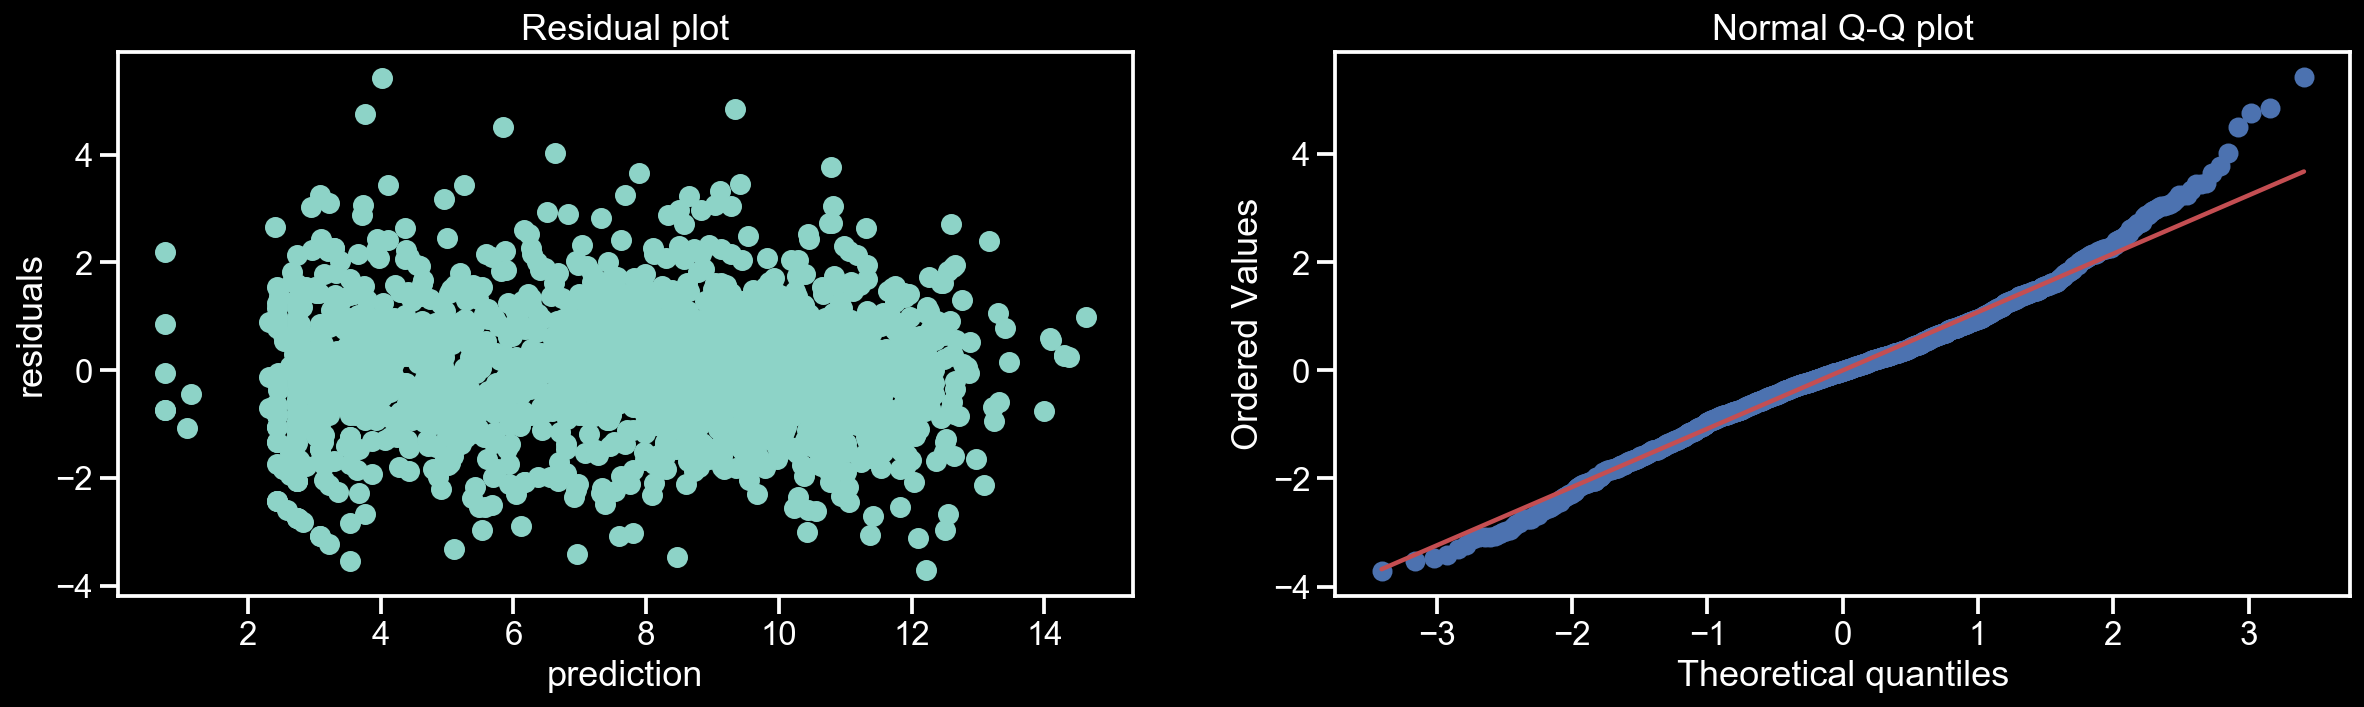

In [39]:
diagnostic_plot(x, y.numRatings)